In [2]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTENC
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

from category_encoders import TargetEncoder
import category_encoders as ce

from sklearn import model_selection

from DFOneHot import DataFrameOneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

C:\Users\Lucas\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [1]:
import timeit
import pickle
import sys
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            precision_recall_curve, roc_curve, accuracy_score
from sklearn.exceptions import NotFittedError
def confusion_plot(matrix, labels=None):
    """ Display binary confusion matrix as a Seaborn heatmap """
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.heatmap(data=matrix, cmap='Blues', annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_title('Confusion Matrix')
    plt.close()
    
    return fig

def roc_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Receiver Operating Characteristic (ROC) curve 
        Set `compare=True` to use this function to compare classifiers. """
    
    fpr, tpr, thresh = roc_curve(y_true, y_probs,
                                 drop_intermediate=False)
    auc = round(roc_auc_score(y_true, y_probs), 2)
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    label = ' '.join([label, f'({auc})']) if compare else None
    sns.lineplot(x=fpr, y=tpr, ax=axis, label=label)
    
    if compare:
        axis.legend(title='Classifier (AUC)', loc='lower right')
    else:
        axis.text(0.72, 0.05, f'AUC = { auc }', fontsize=12,
                  bbox=dict(facecolor='green', alpha=0.4, pad=5))
            
        # Plot No-Info classifier
        axis.fill_between(fpr, fpr, tpr, alpha=0.3, edgecolor='g',
                          linestyle='--', linewidth=2)
        
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('ROC Curve')
    axis.set_xlabel('False Positive Rate [FPR]\n(1 - Specificity)')
    axis.set_ylabel('True Positive Rate [TPR]\n(Sensitivity or Recall)')
    
    plt.close()
    
    return axis if ax else fig

def precision_recall_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Precision-Recall curve.
        Set `compare=True` to use this function to compare classifiers. """
    
    p, r, thresh = precision_recall_curve(y_true, y_probs)
    p, r, thresh = list(p), list(r), list(thresh)
    p.pop()
    r.pop()
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    
    if compare:
        sns.lineplot(r, p, ax=axis, label=label)
        axis.set_xlabel('Recall')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')
    else:
        sns.lineplot(thresh, p, label='Precision', ax=axis)
        axis.set_xlabel('Threshold')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')

        axis_twin = axis.twinx()
        sns.lineplot(thresh, r, color='limegreen', label='Recall', ax=axis_twin)
        axis_twin.set_ylabel('Recall')
        axis_twin.set_ylim(0, 1)
        axis_twin.legend(bbox_to_anchor=(0.24, 0.18))
    
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('Precision Vs Recall')
    
    plt.close()
    
    return axis if ax else fig

def feature_importance_plot(importances, feature_labels, ax=None):
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    sns.barplot(x=importances, y=feature_labels, ax=axis)
    axis.set_title('Feature Importance Measures')
    
    plt.close()
    
    return axis if ax else fig

def train_clf(clf, x_train, y_train, sample_weight=None, refit=False):
    train_time = 0
    
    try:
        if refit:
            raise NotFittedError
        y_pred_train = clf.predict(x_train)
    except NotFittedError:
        start = timeit.default_timer()
        
        if sample_weight is not None:
            clf.fit(x_train, y_train, sample_weight=sample_weight)
        else:
            clf.fit(x_train, y_train)
        
        end = timeit.default_timer()
        train_time = end - start
        
        y_pred_train = clf.predict(x_train)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    return clf, y_pred_train, train_acc, train_time
def model_memory_size(clf):
    return sys.getsizeof(pickle.dumps(clf))

def report(clf, x_train, y_train, x_test, y_test, display_scores=[],
           sample_weight=None, refit=False, importance_plot=False,
           confusion_labels=None, feature_labels=None, verbose=True):
    """ Trains the passed classifier if not already trained and reports
        various metrics of the trained classifier """
    
    dump = dict()
    
    ## Train if not already trained
    clf, train_predictions, \
    train_acc, train_time = train_clf(clf, x_train, y_train,
                                      sample_weight=sample_weight,
                                      refit=refit)
    ## Testing
    start = timeit.default_timer()
    test_predictions = clf.predict(x_test)
    end = timeit.default_timer()
    test_time = end - start
    
    test_acc = accuracy_score(y_test, test_predictions)
    y_probs = clf.predict_proba(x_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_probs)
        
    ## Additional scores
    scores_dict = dict()
    for func in display_scores:
        scores_dict[func.__name__] = [func(y_train, train_predictions),
                                      func(y_test, test_predictions)]
        
    ## Model Memory
    model_mem = round(model_memory_size(clf) / 1024, 2)
    
    print(clf)
    print("\n=============================> TRAIN-TEST DETAILS <======================================")
    
    ## Metrics
    print(f"Train Size: {x_train.shape[0]} samples")
    print(f" Test Size: {x_test.shape[0]} samples")
    print("---------------------------------------------")
    print(f"Training Time: {round(train_time, 3)} seconds")
    print(f" Testing Time: {round(test_time, 3)} seconds")
    print("---------------------------------------------")
    print("Train Accuracy: ", train_acc)
    print(" Test Accuracy: ", test_acc)
    print("---------------------------------------------")
    
    if display_scores:
        for k, v in scores_dict.items():
            score_name = ' '.join(map(lambda x: x.title(), k.split('_')))
            print(f'Train {score_name}: ', v[0])
            print(f' Test {score_name}: ', v[1])
            print()
        print("---------------------------------------------")
    
    print(" Area Under ROC (test): ", roc_auc)
    print("---------------------------------------------")
    print(f"Model Memory Size: {model_mem} kB")
    print("\n=============================> CLASSIFICATION REPORT <===================================")
    
    ## Classification Report
    clf_rep = classification_report(y_test, test_predictions, output_dict=True)
    
    print(classification_report(y_test, test_predictions,
                                target_names=confusion_labels))
    
    
    if verbose:
        print("\n================================> CONFUSION MATRIX <=====================================")
    
        ## Confusion Matrix HeatMap
        display(confusion_plot(confusion_matrix(y_test, test_predictions),
                               labels=confusion_labels))
        print("\n=======================================> PLOTS <=========================================")


        ## Variable importance plot
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        roc_axes = axes[0, 0]
        pr_axes = axes[0, 1]
        importances = None

        if importance_plot:
            if not feature_labels:
                raise RuntimeError("'feature_labels' argument not passed "
                                   "when 'importance_plot' is True")

            try:
                importances = pd.Series(clf.feature_importances_,
                                        index=feature_labels) \
                                .sort_values(ascending=False)
            except AttributeError:
                try:
                    importances = pd.Series(clf.coef_.ravel(),
                                            index=feature_labels) \
                                    .sort_values(ascending=False)
                except AttributeError:
                    pass

            if importances is not None:
                # Modifying grid
                grid_spec = axes[0, 0].get_gridspec()
                for ax in axes[:, 0]:
                    ax.remove()   # remove first column axes
                large_axs = fig.add_subplot(grid_spec[0:, 0])

                # Plot importance curve
                feature_importance_plot(importances=importances.values,
                                        feature_labels=importances.index,
                                        ax=large_axs)
                large_axs.axvline(x=0)

                # Axis for ROC and PR curve
                roc_axes = axes[0, 1]
                pr_axes = axes[1, 1]
            else:
                # remove second row axes
                for ax in axes[1, :]:
                    ax.remove()
        else:
            # remove second row axes
            for ax in axes[1, :]:
                ax.remove()


        ## ROC and Precision-Recall curves
        clf_name = clf.__class__.__name__
        roc_plot(y_test, y_probs, clf_name, ax=roc_axes)
        precision_recall_plot(y_test, y_probs, clf_name, ax=pr_axes)

        fig.subplots_adjust(wspace=5)
        fig.tight_layout()
        display(fig)
    
    ## Dump to report_dict
    dump = dict(clf=clf, accuracy=[train_acc, test_acc], **scores_dict,
                train_time=train_time, train_predictions=train_predictions,
                test_time=test_time, test_predictions=test_predictions,
                test_probs=y_probs, report=clf_rep, roc_auc=roc_auc,
                model_memory=model_mem)
    
    return clf, dump

In [3]:
%%time
# train_values = pd.read_csv("train_values.csv", dtype ={'geo_level_1_id': str, 'geo_level_2_id': str, 'geo_level_3_id': str})
# train_labels = pd.read_csv("train_labels.csv")
# test_values = pd.read_csv("test_values.csv", dtype ={'geo_level_1_id': str, 'geo_level_2_id': str, 'geo_level_3_id': str})

train_values = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_values = pd.read_csv("test_values.csv")

Wall time: 624 ms


In [4]:
# find number of rows and columns
print(
f'train_values shape: {train_values.shape}\n\
train_labels shape: {train_labels.shape}\n\
test_values shape: {test_values.shape}')

train_values shape: (260601, 39)
train_labels shape: (260601, 2)
test_values shape: (86868, 39)


In [5]:
def new_fea(df):
    df['floor_age'] = df.count_floors_pre_eq * df.age
    df['height/floor'] = df.height_percentage / df.count_floors_pre_eq
    df['height/area'] = df.height_percentage / df.area_percentage
new_fea(train_values)
new_fea(test_values)

In [6]:
test_values.shape

(86868, 42)

In [7]:
def target_encode_multiclass(X,y,cols): #X,y are pandas df and series, cols is a list of column variables
    y=y.astype(str)   #convert to string to onehot encode
    enc=ce.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)
    class_names=y_onehot.columns  #names of onehot encoded columns
#     X_obj=X.select_dtypes('object') #separate categorical columns
    X_col=X[cols].copy()
    for c in cols:
        X_col[c] = X_col[c].astype(str)
    X_rem=X[[x for x in X.columns if x not in cols]].copy() # remaining columns
    for class_ in class_names:
      
        enc=ce.TargetEncoder(smoothing=0.001)
        enc.fit(X_col,y_onehot[class_]) #convert all categorical 
        temp=enc.transform(X_col)       #columns for class_
        temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
        X_rem=pd.concat([X_rem,temp],axis=1)    #add to original dataset
    X_rem = pd.concat([X_rem, X[cols]], axis=1)  
    return X_rem

In [8]:
# possible values and distributions of the label
train_labels.damage_grade.value_counts()

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

In [9]:
train_values.head(2)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,floor_age,height/floor,height/area
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,60,2.5,0.833333
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,20,3.5,0.875000


# Splitting the Data

In [10]:
cols_to_drop = ['building_id']

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_values.drop(columns=cols_to_drop), train_labels['damage_grade'], test_size=0.2, random_state=42)

type(X_train)
type(y_train)

pandas.core.series.Series

In [12]:
X_train = target_encode_multiclass(X_train, y_train, ['geo_level_1_id', 'geo_level_2_id','geo_level_3_id'])

In [13]:
%%time
for col in ['geo_level_1_id', 'geo_level_2_id','geo_level_3_id']:
    uniq_v = X_test[col].unique()
    for v1 in uniq_v:
        for v2 in [1,2,3]:
            if v1 in X_train[col].unique():
                X_test.loc[X_test[col]==v1, f'{col}_damage_grade_{v2}'] = \
                    X_train.loc[(X_train[col]==v1),f'{col}_damage_grade_{v2}'].values[0]
            else:
                X_test.loc[X_test[col]==v1, f'{col}_damage_grade_{v2}'] = 0

Wall time: 2min 20s


In [14]:
categ_col = []
for col in X_train.columns:
    if X_train[col].dtypes not in ('int64', 'float64'):
        categ_col.append(col)
#         print(train_values[col].value_counts(),'\n')
categ_col

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

In [15]:
transformer = ColumnTransformer(transformers=[('cat', DataFrameOneHotEncoder(handle_unknown='ignore'), categ_col)], 
                                remainder='passthrough')

In [36]:
def perf(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average='micro')
    
    
    y_pred = model.predict(X_test)
#     print(y_pred)
#     predictions = [round(value) for value in y_pred]
    predictions = y_pred
    class_names = [str(x) for x in model.classes_]
    print(classification_report(y_test, y_pred, target_names=class_names))
    accuracy = accuracy_score(y_test, predictions)
#     print("testing Accuracy: %.2f%%" % (accuracy * 100.0))
    print(f'training f1 score: {round(train_f1, 4)}')
    print("testing f1 score: {:.4f}".format(f1_score(y_test, predictions, average='micro')))

# Random Forest

In [17]:
%%time
pipe = Pipeline(steps=[("preprocessing", transformer),
                       ('rf', RandomForestClassifier(min_samples_split=50,
                                        n_estimators=1000))],
               verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.5s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 5.9min
Wall time: 5min 54s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  DataFrameOneHotEncoder(handle_unknown='ignore'),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status'])])),
                ('rf',
                 RandomForestClassifier(min_samples_split=50,
                                        n_estimators=1000))],
         verbose=True)

In [37]:
perf(pipe, X_train, y_train, X_test, y_test)
print(f'submission f1 score: 0.7451')

              precision    recall  f1-score   support

           1       0.69      0.52      0.59      5170
           2       0.74      0.85      0.79     29487
           3       0.76      0.64      0.69     17464

    accuracy                           0.75     52121
   macro avg       0.73      0.67      0.69     52121
weighted avg       0.75      0.75      0.74     52121

training f1 score: 0.8045
testing f1 score: 0.7461
submission f1 score: 0.7451


In [56]:
pipe[1].estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'random_state',
 'ccp_alpha')

In [63]:
print("-------Final model: Random Forest--------\n")
for a in pipe[1].estimator_params:
    print(f"{a} = '{getattr(pipe[1], a)}'")
print(f"n_estimators = '1000'")

-------Final model: Random Forest--------

criterion = 'gini'
max_depth = 'None'
min_samples_split = '50'
min_samples_leaf = '1'
min_weight_fraction_leaf = '0.0'
max_features = 'auto'
max_leaf_nodes = 'None'
min_impurity_decrease = '0.0'
random_state = 'None'
ccp_alpha = '0.0'
n_estimators = '1000'


In [58]:
pipe[1].estimators_

[DecisionTreeClassifier(max_features='auto', min_samples_split=50,
                        random_state=1844584097),
 DecisionTreeClassifier(max_features='auto', min_samples_split=50,
                        random_state=280467875),
 DecisionTreeClassifier(max_features='auto', min_samples_split=50,
                        random_state=1547808115),
 DecisionTreeClassifier(max_features='auto', min_samples_split=50,
                        random_state=1776232028),
 DecisionTreeClassifier(max_features='auto', min_samples_split=50,
                        random_state=2071302874),
 DecisionTreeClassifier(max_features='auto', min_samples_split=50,
                        random_state=383458309),
 DecisionTreeClassifier(max_features='auto', min_samples_split=50,
                        random_state=184395814),
 DecisionTreeClassifier(max_features='auto', min_samples_split=50,
                        random_state=1240801631),
 DecisionTreeClassifier(max_features='auto', min_samples_split=50,


In [41]:
dir(pipe[1])

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_oob_predictions',
 '_estimator_type',
 '_get_oob_predictions',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score_and_attributes',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 'bootstrap',
 'ccp_alpha',
 'class_weight'

In [29]:
y_pred = pipe.predict(X_test)
metrics.confusion_matrix(y_test,y_pred)

array([[ 2682,  2398,    90],
       [ 1059, 25062,  3366],
       [  119,  6204, 11141]], dtype=int64)

In [19]:
# RF feature importance
ohe_col = pipe['preprocessing'].transformers_[0][1].column_names_
passthrough_col_i = np.array(pipe['preprocessing'].transformers_[1][2])
rem_col = list(X_train.columns[passthrough_col_i])
feature_names = [y for x in ohe_col for y in x] + rem_col
f_importance = pipe.named_steps['rf'].feature_importances_

In [25]:
from sklearn import metrics
primary_eval_metric = metrics.f1_score
confusion_lbs = ['Not Survived', 'Survived']

In [26]:
xgb_clf_default, xgb_report_default = report(pipe, X_train, y_train,
                                             X_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

ValueError: multi_class must be in ('ovo', 'ovr')

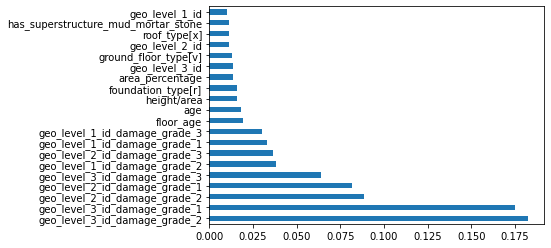

In [29]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(pipe.named_steps['rf'].feature_importances_, index=feature_names)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


# Catboost

In [41]:
%%time
pipe = Pipeline(steps=[("preprocessing", transformer),
                       ('catboost', CatBoostClassifier())],
               verbose=True)

pipe.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.5s
Learning rate set to 0.103895
0:	learn: 1.0081407	total: 176ms	remaining: 2m 55s
1:	learn: 0.9379490	total: 221ms	remaining: 1m 50s
2:	learn: 0.8822975	total: 264ms	remaining: 1m 27s
3:	learn: 0.8364730	total: 310ms	remaining: 1m 17s
4:	learn: 0.7986968	total: 357ms	remaining: 1m 10s
5:	learn: 0.7665293	total: 403ms	remaining: 1m 6s
6:	learn: 0.7392604	total: 451ms	remaining: 1m 3s
7:	learn: 0.7151789	total: 498ms	remaining: 1m 1s
8:	learn: 0.6948902	total: 540ms	remaining: 59.5s
9:	learn: 0.6776522	total: 589ms	remaining: 58.3s
10:	learn: 0.6623015	total: 655ms	remaining: 58.9s
11:	learn: 0.6491421	total: 721ms	remaining: 59.4s
12:	learn: 0.6370226	total: 766ms	remaining: 58.2s
13:	learn: 0.6265959	total: 831ms	remaining: 58.6s
14:	learn: 0.6172473	total: 879ms	remaining: 57.7s
15:	learn: 0.6085729	total: 926ms	remaining: 56.9s
16:	learn: 0.6021166	total: 969ms	remaining: 56s
17:	learn: 0.5950582	total: 1.02s	remai

159:	learn: 0.5113622	total: 7.89s	remaining: 41.4s
160:	learn: 0.5112942	total: 7.93s	remaining: 41.3s
161:	learn: 0.5111988	total: 8s	remaining: 41.4s
162:	learn: 0.5110965	total: 8.05s	remaining: 41.3s
163:	learn: 0.5110270	total: 8.1s	remaining: 41.3s
164:	learn: 0.5109716	total: 8.14s	remaining: 41.2s
165:	learn: 0.5109103	total: 8.18s	remaining: 41.1s
166:	learn: 0.5108853	total: 8.23s	remaining: 41s
167:	learn: 0.5108015	total: 8.28s	remaining: 41s
168:	learn: 0.5107395	total: 8.32s	remaining: 40.9s
169:	learn: 0.5106929	total: 8.38s	remaining: 40.9s
170:	learn: 0.5106276	total: 8.41s	remaining: 40.8s
171:	learn: 0.5105615	total: 8.45s	remaining: 40.7s
172:	learn: 0.5105262	total: 8.49s	remaining: 40.6s
173:	learn: 0.5104504	total: 8.53s	remaining: 40.5s
174:	learn: 0.5103925	total: 8.57s	remaining: 40.4s
175:	learn: 0.5103215	total: 8.63s	remaining: 40.4s
176:	learn: 0.5101755	total: 8.68s	remaining: 40.4s
177:	learn: 0.5101353	total: 8.73s	remaining: 40.3s
178:	learn: 0.510065

321:	learn: 0.5021508	total: 15.5s	remaining: 32.7s
322:	learn: 0.5021276	total: 15.6s	remaining: 32.7s
323:	learn: 0.5020874	total: 15.6s	remaining: 32.6s
324:	learn: 0.5020354	total: 15.7s	remaining: 32.5s
325:	learn: 0.5020095	total: 15.8s	remaining: 32.6s
326:	learn: 0.5019691	total: 15.8s	remaining: 32.5s
327:	learn: 0.5019041	total: 15.8s	remaining: 32.4s
328:	learn: 0.5018790	total: 15.9s	remaining: 32.4s
329:	learn: 0.5018341	total: 16s	remaining: 32.4s
330:	learn: 0.5017901	total: 16s	remaining: 32.4s
331:	learn: 0.5017503	total: 16.1s	remaining: 32.3s
332:	learn: 0.5016963	total: 16.1s	remaining: 32.3s
333:	learn: 0.5016645	total: 16.2s	remaining: 32.2s
334:	learn: 0.5016264	total: 16.2s	remaining: 32.2s
335:	learn: 0.5015946	total: 16.3s	remaining: 32.1s
336:	learn: 0.5015484	total: 16.3s	remaining: 32.1s
337:	learn: 0.5015149	total: 16.4s	remaining: 32s
338:	learn: 0.5014831	total: 16.4s	remaining: 32s
339:	learn: 0.5014436	total: 16.4s	remaining: 31.9s
340:	learn: 0.501402

483:	learn: 0.4960284	total: 23.4s	remaining: 24.9s
484:	learn: 0.4960093	total: 23.4s	remaining: 24.9s
485:	learn: 0.4959697	total: 23.5s	remaining: 24.9s
486:	learn: 0.4959247	total: 23.6s	remaining: 24.8s
487:	learn: 0.4959087	total: 23.6s	remaining: 24.8s
488:	learn: 0.4958594	total: 23.7s	remaining: 24.7s
489:	learn: 0.4958168	total: 23.7s	remaining: 24.7s
490:	learn: 0.4957767	total: 23.7s	remaining: 24.6s
491:	learn: 0.4957496	total: 23.8s	remaining: 24.6s
492:	learn: 0.4957135	total: 23.8s	remaining: 24.5s
493:	learn: 0.4956489	total: 23.9s	remaining: 24.4s
494:	learn: 0.4956282	total: 23.9s	remaining: 24.4s
495:	learn: 0.4955788	total: 23.9s	remaining: 24.3s
496:	learn: 0.4955625	total: 24s	remaining: 24.3s
497:	learn: 0.4955380	total: 24s	remaining: 24.2s
498:	learn: 0.4955150	total: 24.1s	remaining: 24.2s
499:	learn: 0.4954714	total: 24.1s	remaining: 24.1s
500:	learn: 0.4954270	total: 24.2s	remaining: 24.1s
501:	learn: 0.4953906	total: 24.2s	remaining: 24s
502:	learn: 0.4953

642:	learn: 0.4908931	total: 31s	remaining: 17.2s
643:	learn: 0.4908597	total: 31s	remaining: 17.1s
644:	learn: 0.4907986	total: 31.1s	remaining: 17.1s
645:	learn: 0.4907731	total: 31.1s	remaining: 17s
646:	learn: 0.4907463	total: 31.1s	remaining: 17s
647:	learn: 0.4907212	total: 31.2s	remaining: 16.9s
648:	learn: 0.4907014	total: 31.2s	remaining: 16.9s
649:	learn: 0.4906753	total: 31.3s	remaining: 16.8s
650:	learn: 0.4906596	total: 31.3s	remaining: 16.8s
651:	learn: 0.4906256	total: 31.4s	remaining: 16.8s
652:	learn: 0.4905854	total: 31.4s	remaining: 16.7s
653:	learn: 0.4905671	total: 31.5s	remaining: 16.6s
654:	learn: 0.4905298	total: 31.5s	remaining: 16.6s
655:	learn: 0.4905071	total: 31.6s	remaining: 16.6s
656:	learn: 0.4904776	total: 31.6s	remaining: 16.5s
657:	learn: 0.4904628	total: 31.7s	remaining: 16.5s
658:	learn: 0.4904330	total: 31.7s	remaining: 16.4s
659:	learn: 0.4903944	total: 31.7s	remaining: 16.3s
660:	learn: 0.4903406	total: 31.8s	remaining: 16.3s
661:	learn: 0.490301

801:	learn: 0.4864385	total: 38.5s	remaining: 9.5s
802:	learn: 0.4863728	total: 38.5s	remaining: 9.45s
803:	learn: 0.4863562	total: 38.6s	remaining: 9.41s
804:	learn: 0.4863205	total: 38.6s	remaining: 9.36s
805:	learn: 0.4862988	total: 38.7s	remaining: 9.32s
806:	learn: 0.4862785	total: 38.7s	remaining: 9.27s
807:	learn: 0.4862434	total: 38.8s	remaining: 9.22s
808:	learn: 0.4862313	total: 38.8s	remaining: 9.17s
809:	learn: 0.4862079	total: 38.9s	remaining: 9.13s
810:	learn: 0.4861856	total: 39s	remaining: 9.08s
811:	learn: 0.4861557	total: 39s	remaining: 9.03s
812:	learn: 0.4861265	total: 39.1s	remaining: 8.98s
813:	learn: 0.4861111	total: 39.1s	remaining: 8.94s
814:	learn: 0.4860693	total: 39.2s	remaining: 8.89s
815:	learn: 0.4860470	total: 39.2s	remaining: 8.85s
816:	learn: 0.4860422	total: 39.3s	remaining: 8.8s
817:	learn: 0.4860109	total: 39.3s	remaining: 8.75s
818:	learn: 0.4860027	total: 39.4s	remaining: 8.7s
819:	learn: 0.4859910	total: 39.4s	remaining: 8.65s
820:	learn: 0.48596

960:	learn: 0.4822973	total: 46s	remaining: 1.87s
961:	learn: 0.4822828	total: 46s	remaining: 1.82s
962:	learn: 0.4822515	total: 46.1s	remaining: 1.77s
963:	learn: 0.4822248	total: 46.2s	remaining: 1.72s
964:	learn: 0.4822102	total: 46.2s	remaining: 1.68s
965:	learn: 0.4821917	total: 46.2s	remaining: 1.63s
966:	learn: 0.4821548	total: 46.3s	remaining: 1.58s
967:	learn: 0.4821298	total: 46.3s	remaining: 1.53s
968:	learn: 0.4821049	total: 46.4s	remaining: 1.48s
969:	learn: 0.4820756	total: 46.4s	remaining: 1.44s
970:	learn: 0.4820511	total: 46.5s	remaining: 1.39s
971:	learn: 0.4820210	total: 46.5s	remaining: 1.34s
972:	learn: 0.4819883	total: 46.6s	remaining: 1.29s
973:	learn: 0.4819620	total: 46.6s	remaining: 1.24s
974:	learn: 0.4819304	total: 46.7s	remaining: 1.2s
975:	learn: 0.4818870	total: 46.7s	remaining: 1.15s
976:	learn: 0.4818590	total: 46.8s	remaining: 1.1s
977:	learn: 0.4818360	total: 46.8s	remaining: 1.05s
978:	learn: 0.4818168	total: 46.9s	remaining: 1s
979:	learn: 0.4817914

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  DataFrameOneHotEncoder(handle_unknown='ignore'),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status'])])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x0000024ABA569E48>)],
         verbose=True)

In [51]:
perf(pipe, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           1       0.68      0.54      0.60      5170
           2       0.75      0.84      0.79     29487
           3       0.75      0.64      0.69     17464

    accuracy                           0.74     52121
   macro avg       0.73      0.67      0.70     52121
weighted avg       0.74      0.74      0.74     52121

training f1 score: 0.7799932847275519
testing f1 score = 0.7430


# LGBM

In [53]:
%%time
pipe = Pipeline(steps=[("preprocessing", transformer),
                       ('lgbm', LGBMClassifier())],
               verbose=True)
param_grid = {

        'bagging_fraction': (0.5, 0.8),
        'bagging_frequency': (5, 8),

        'feature_fraction': (0.5, 1),
        'max_depth': (10, 13),
        'n_estimators': (100, 1000),
        'learning_rate': (0.01, 0.3),
        'min_data_in_leaf': (90, 120),
        'num_leaves': (1200, 1550)

}

search = model_selection.RandomizedSearchCV(pipe, param_grid, cv=3, n_jobs=-1, scoring='f1_micro', 
                                            return_train_score=False, verbose=2, random_state=1, n_iter=20)

search = search.fit(X_train, y_train)

# pipe.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.5s
[Pipeline] .............. (step 2 of 2) Processing lgbm, total=   2.0s
Wall time: 2.5 s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  DataFrameOneHotEncoder(handle_unknown='ignore'),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status'])])),
                ('lgbm', LGBMClassifier())],
         verbose=True)

In [ ]:
perf(search, X_train, y_train, X_test, y_test)

In [54]:
perf(pipe, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           1       0.66      0.54      0.60      5170
           2       0.74      0.84      0.79     29487
           3       0.75      0.64      0.69     17464

    accuracy                           0.74     52121
   macro avg       0.72      0.67      0.69     52121
weighted avg       0.74      0.74      0.74     52121

training f1 score: 0.7700211051419801
testing f1 score = 0.7396


# FLAML

In [59]:
from flaml import AutoML
automl = AutoML()
automl_settings = {
    "flaml__time_budget": 300,  # in seconds
    "flaml__metric": 'micro_f1',
    "flaml__eval_method": 'cv',
    "flaml__n_splits": 3,
    "flaml__task": 'classification',
    "flaml__log_file_name": "EQ.log",
    "flaml__n_jobs": -1
}

In [60]:
%%time
pipe = Pipeline(steps=[("preprocessing", transformer),
                       ('flaml', automl)],
               verbose=True)

pipe.fit(X_train, y_train, **automl_settings)

[flaml.automl: 12-12 14:08:14] {1926} INFO - task = classification
[flaml.automl: 12-12 14:08:14] {1928} INFO - Data split method: stratified
[flaml.automl: 12-12 14:08:14] {1932} INFO - Evaluation method: cv
[flaml.automl: 12-12 14:08:14] {1999} INFO - Minimizing error metric: 1-micro_f1


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.5s


[flaml.automl: 12-12 14:08:14] {2051} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 12-12 14:08:15] {2291} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-12 14:08:16] {2405} INFO - Estimated sufficient time budget=11274s. Estimated necessary time budget=277s.
[flaml.automl: 12-12 14:08:16] {2485} INFO -  at 1.6s,	estimator lgbm's best error=0.3030,	best estimator lgbm's best error=0.3030
[flaml.automl: 12-12 14:08:16] {2291} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-12 14:08:17] {2485} INFO -  at 2.7s,	estimator lgbm's best error=0.3030,	best estimator lgbm's best error=0.3030
[flaml.automl: 12-12 14:08:17] {2291} INFO - iteration 2, current learner lgbm
[flaml.automl: 12-12 14:08:18] {2485} INFO -  at 3.8s,	estimator lgbm's best error=0.2586,	best estimator lgbm's best error=0.2586
[flaml.automl: 12-12 14:08:18] {2291} INFO - iteration 3, current learner xgboost
[flaml

[Pipeline] ............. (step 2 of 2) Processing flaml, total= 5.1min
Wall time: 5min 3s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  DataFrameOneHotEncoder(handle_unknown='ignore'),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status'])])),
                ('flaml',
                 AutoML(append_log=False, auto_augment=Tru...
                        log_file_name='', log_training_metric=False,
                     

In [61]:
perf(pipe, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           1       0.66      0.54      0.60      5170
           2       0.75      0.83      0.79     29487
           3       0.75      0.64      0.69     17464

    accuracy                           0.74     52121
   macro avg       0.72      0.67      0.69     52121
weighted avg       0.74      0.74      0.74     52121

training f1 score: 0.7765349194167306
testing f1 score = 0.7402


# Stacking

In [80]:
%%time

# clf1 = Pipeline(steps=[("preprocessing", transformer),
#                        ('DT', DecisionTreeClassifier(max_depth=4))],
#                verbose=True)
clf1 = make_pipeline(transformer, DecisionTreeClassifier(max_depth=4))
clf1.fit(X_train, y_train)
clf2 = Pipeline(steps=[("preprocessing", transformer),
                       ('KNN', KNeighborsClassifier(n_neighbors=7))],
               verbose=True)
clf2.fit(X_train, y_train)
clf4 = Pipeline(steps=[("preprocessing", transformer),
                       ('rf', RandomForestClassifier(n_estimators=1000, min_samples_split=50, random_state=0))],
               verbose=True)
clf4.fit(X_train, y_train)
clf5 = Pipeline(steps=[("preprocessing", transformer),
                       ('xgb', XGBClassifier(max_depth=8, n_estimators=180, random_state=0))],
               verbose=True)                       
clf5.fit(X_train, y_train)

classifiers=[('DT', clf1), ('KNN', clf2), ('RF', clf4), ('XGB', clf5)]

sclf = StackingClassifier(
    classifiers=[clf1, clf2, clf4], meta_classifier=XGBClassifier(), fit_base_estimators=False,
    use_probas=True, average_probas=False)
pipe = Pipeline([
                 ('classifier', sclf)])

pipe.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing KNN, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.5s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 5.5min
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing xgb, total= 9.6min
Wall time: 28min 12s


Pipeline(steps=[('classifier',
                 StackingClassifier(classifiers=[Pipeline(steps=[('columntransformer',
                                                                  ColumnTransformer(remainder='passthrough',
                                                                                    transformers=[('cat',
                                                                                                   DataFrameOneHotEncoder(handle_unknown='ignore'),
                                                                                                   ['land_surface_condition',
                                                                                                    'foundation_type',
                                                                                                    'roof_type',
                                                                                                    'ground_floor_type',
                                        

In [ ]:
for pipe in [clf1, clf2, clf4]:
    print(f'\n-----------------{pipe}---------------\n')
    print(perf(pipe, X_train, y_train, X_test, y_test))
    


-----------------Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  DataFrameOneHotEncoder(handle_unknown='ignore'),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4))])---------------

              precision    recall  f1-sco

In [87]:
model = pipe
y_train_pred = model.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred, average='micro')

In [88]:
y_pred = model.predict(X_test)
#     print(y_pred)
#     predictions = [round(value) for value in y_pred]
predictions = y_pred
# class_names = [str(x) for x in model.classes_]
# print(classification_report(y_test, y_pred, target_names=class_names))
accuracy = accuracy_score(y_test, predictions)
#     print("testing Accuracy: %.2f%%" % (accuracy * 100.0))
print(f'training f1 score: {train_f1}')
print("testing f1 score = {:.4f}".format(f1_score(y_test, predictions, average='micro')))

training f1 score: 0.834535686876439
testing f1 score = 0.7347


# XGBoost

In [30]:
%%time
pipe3 = Pipeline(steps=[("preprocessing", transformer),
                       ('xgb', XGBClassifier(max_depth=8, n_estimators=180))],
               verbose=True)

pipe3.fit(X_train, y_train)
# print(df_ohe.fit_transform(train_values.head(3)))

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing xgb, total= 9.8min
Wall time: 9min 51s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  DataFrameOneHotEncoder(handle_unknown='ignore'),
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
                                                   'position',
                                                   'plan_configuration',
                                                   'legal_ownership_status'])])),
                ('xgb',
                 XGBClassifier(max_depth=8, n_estimators=180,
                               objective='multi:softprob'))],
         verbose=True)

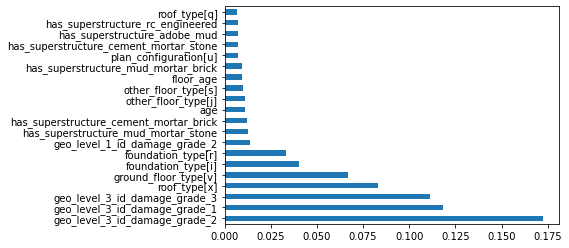

In [32]:
# XGB feature importance
ohe_col = pipe3['preprocessing'].transformers_[0][1].column_names_
passthrough_col_i = np.array(pipe3['preprocessing'].transformers_[1][2])
rem_col = list(X_train.columns[passthrough_col_i])
feature_names = [y for x in ohe_col for y in x] + rem_col
f_importance = pipe3.named_steps['xgb'].feature_importances_

import matplotlib.pyplot as plt

feat_importances = pd.Series(pipe3.named_steps['xgb'].feature_importances_, index=feature_names)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [33]:
perf(pipe3, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           1       0.67      0.54      0.60      5170
           2       0.74      0.84      0.79     29487
           3       0.75      0.64      0.69     17464

    accuracy                           0.74     52121
   macro avg       0.72      0.67      0.69     52121
weighted avg       0.74      0.74      0.74     52121

training f1 score: 0.7881763238679969
testing f1 score = 0.7415


# make prediction on official test data set

In [22]:
%%time
for col in ['geo_level_1_id', 'geo_level_2_id','geo_level_3_id']:
    uniq_v = test_values[col].unique()
    for v1 in uniq_v:
        for v2 in [1,2,3]:
            if v1 in X_train[col].unique():
                test_values.loc[test_values[col]==v1, f'{col}_damage_grade_{v2}'] = \
                    X_train.loc[(X_train[col]==v1),f'{col}_damage_grade_{v2}'].values[0]
            else:
                test_values.loc[test_values[col]==v1, f'{col}_damage_grade_{v2}'] = 0

Wall time: 3min 1s


In [23]:
y_pred_subm = pipe.predict(test_values)

In [24]:
submission_file = pd.DataFrame({'building_id':test_values.building_id, 'damage_grade':y_pred_subm})
submission_file

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [25]:
submission_file.to_csv('sibmission_file.csv', index=False)